https://archive.ics.uci.edu/ml/datasets/student+performance

In [1]:
# A - with all variables from Table 1 except G3 (the
# output);
# B - similar to A but without G2 (the second period
# grade); and
# C - similar to B but without G1 (the first period

# 1. Binary classification – pass if G310, else fail;
# 2. 5-Level classification – based on the Erasmus1
# grade conversion system (Table 2);
# 3. Regression – the G3 value (numeric output between
# 0 and 20).


# Table 2: The five-level classification system
# I II III IV V
# Country (excellent/very good) (good) (satisfactory) (sufficient) (fail)
# Portugal/France 16-20 14-15 12-13 10-11 0-9
# Ireland A B C D F

In [3]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.utils import shuffle
from scipy.stats import ranksums
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import warnings
from math import log2

def KFoldCV(model, data, n_fold=10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
#         if i == n_fold-1:
#             end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, y = test[:,:-1], test[:,-1]
        predictY = model.fit(X_train, y_train).predict(X_test)
        mae = np.mean(abs((y-predictY)))
        stdErr = np.std(((y-predictY)))
        error=sum((y-predictY)**2)
        RMSE=np.sqrt(error/len(y))
        MAC = np.dot(y,predictY)**2/(np.dot(y, y)*np.dot(predictY, predictY))
#         print(mae, stdErr, RMSE, MAC)
        results[i,:] = [mae, stdErr, RMSE, MAC]
    return results

warnings.filterwarnings('ignore')

# data = pd.read_csv('./student-mat.csv', sep=';')
# por = pd.read_csv('./student-por.csv', sep=';')
# combine = pd.merge(math, por, on=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"])
# data = data.values
# data = shuffle(data)

In [46]:
data = pd.read_csv('./student-mat.csv', sep=';')
cats = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
oe = OrdinalEncoder()
for c in cats:
    oe.fit(data[c].values.reshape(-1,1))
    data[c] = np.asarray(oe.transform(data[c].values.reshape(-1,1)),dtype=int)
#     np.asarray(data['gender'],dtype=int)
data = data.values
data = shuffle(data)

In [47]:
# data.shape (395, 33)
# np.savetxt('math.txt',data)
data.shape

(395, 33)

# G3

In [1]:
# from sklearn.model_selection import GridSearchCV
# # F(x) = F'(x) + Error(x)
# # F(x) = F'(x) + noise * Error(x)
# # F(x) = weighted * F'(x) + noise * Error(x)
# # train F'(x)
# # train Error(x)

# def gridSearch4CatBoost(X,y,n_estimators,max_depth):
# #     cbc = CatBoostRegressor(verbose=False,task_type="GPU",devices='0:1')
# # #     cbc = RandomForestRegressor()
# #     grid = {'max_depth': [3,4,5],'n_estimators':[100,300,500]}
# #     gscv = GridSearchCV (estimator = cbc, param_grid = grid, cv = 10)
# #     gscv.fit(X,y)
# #     return gscv.best_estimator_
#     return CatBoostRegressor(verbose=False,task_type="GPU",devices='0:1',n_estimators=n_estimators,max_depth=max_depth).fit(X,y)

# def KFoldCV2(data,n_estimators,max_depth, n_fold=10):
# #     num = len(data)
#     diff = int(len(data)/n_fold)
#     results = np.zeros((n_fold, 4))
#     for i in range(n_fold):
#         begin = diff*i
#         end = diff*(i+1)
# #         if i == n_fold-1:
# #             end = -1
#         test = data[begin:end]
#         train = deepcopy(data)
#         train = np.delete(train, range(begin, end),axis=0)
#         X_train, y_train = train[:,:-1], train[:,-1]
#         X_test, y = test[:,:-1], test[:,-1]
# #        gridSearch4CatBoost grid search for F'(x) and Error(x)
#         model = gridSearch4CatBoost(X_train, y_train,n_estimators,max_depth)
#         errorY = y_train - model.predict(X_train)
#         predictYe = gridSearch4CatBoost(X_train, errorY,n_estimators,max_depth).predict(X_test)
#         predictYp = model.predict(X_test)
#         predictY = predictYp + predictYe
#         mae = np.mean(abs((y-predictY)))
#         stdErr = np.std(((y-predictY)))
#         error=sum((y-predictY)**2)
#         RMSE=np.sqrt(error/len(y))
#         MAC = np.dot(y,predictY)**2/(np.dot(y, y)*np.dot(predictY, predictY))
# #         print(mae, stdErr, RMSE, MAC)
#         results[i,:] = [mae, stdErr, RMSE, MAC]
#     return results

# n_estimators= [100,300,500]
# max_depth = [3,4, 5]
# n_estimators  = [300]
# max_depth = [4]
# epochs=20
# cats = np.zeros((epochs,4))
# for i in n_estimators:
#     for j in max_depth:
#         for epoch in range(epochs):
#             data = shuffle(data)
#             result = KFoldCV2(data,i,j)
#             cats[epoch,:] = np.mean(result, axis=0)
#         print(np.mean(cats, axis=0))

In [2]:
# cats

In [48]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# F(x) = F'(x) + Error(x)
# F(x) = F'(x) + noise * Error(x)
# F(x) = weighted * F'(x) + noise * Error(x)
# train F'(x)
# train Error(x)

def gridSearch4CatBoost(X,y,n_estimators,max_depth):
#     cbc = CatBoostRegressor(verbose=False,task_type="GPU",devices='0:1')
# #     cbc = RandomForestRegressor()
#     grid = {'max_depth': [3,4,5],'n_estimators':[100,300,500]}
#     gscv = GridSearchCV (estimator = cbc, param_grid = grid, cv = 10)
#     gscv.fit(X,y)
#     return gscv.best_estimator_
    return CatBoostRegressor(verbose=False,task_type="GPU",devices='0:1',n_estimators=n_estimators,max_depth=max_depth).fit(X,y)

def KFoldCV2(data,n_estimators,max_depth, n_fold=10):
#     num = len(data)
    diff = int(len(data)/n_fold)
    results = np.zeros((n_fold, 4))
    for i in range(n_fold):
        begin = diff*i
        end = diff*(i+1)
        if i == n_fold-1:
            end = -1
        test = data[begin:end]
        train = deepcopy(data)
        train = np.delete(train, range(begin, end),axis=0)
        X_train, y_train = train[:,:-1], train[:,-1]
        X_test, y = test[:,:-1], test[:,-1]
#        gridSearch4CatBoost grid search for F'(x) and Error(x)
        model = gridSearch4CatBoost(X_train, y_train,n_estimators,max_depth)
        errorY = y_train - model.predict(X_train)
#         model = gridSearch4CatBoost(np.hstack((X_train,errorY.reshape((len(errorY),1)))), y_train,n_estimators,max_depth)
#         errorYBi = [1 if i > 0 else -1 for i in errorY]
#         modelDir = CatBoostClassifier(verbose=False,task_type="GPU",devices='0:1',n_estimators=n_estimators,max_depth=max_depth).fit(X_train, errorYBi)
#         yDir = modelDir.predict(X_train)
#         print(yDir)
        predictYe = gridSearch4CatBoost(X_train, errorY,n_estimators,max_depth).predict(X_test)
#         predictYe = gridSearch4CatBoost(X_train, errorY,n_estimators,max_depth).predict(np.hstack((X_test,predictYe))
#         predictYdir = modelDir.predict(X_test)
#         predictYp = model.predict(np.hstack((X_test,predictYe.reshape((len(predictYe),1)))))
        predictYp = model.predict(X_test)
        predictY = predictYp + predictYe#*predictYdir
#         predictY = predictY.astype(int)
#         print(predictYe)
#         print(predictYp)
#         print(predictY)
#         print(y)
        mae = np.mean(abs((y-predictY)))
        stdErr = np.std(y-predictY)
        error=sum((y-predictY)**2)
        RMSE=np.sqrt(error/len(y))
        MAC = np.dot(y,predictY)**2/(np.dot(y, y)*np.dot(predictY, predictY))
#         print(mae, stdErr, RMSE, MAC)
        results[i,:] = [mae, stdErr, RMSE, MAC]
    return results

n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [300]
max_depth = [5]
epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            result = KFoldCV2(data,i,j)
            cats[epoch,:] = np.mean(result, axis=0)
        print(np.mean(cats, axis=0))

[0.80256957 1.09400242 1.10990019 0.9815073 ]


In [49]:
cats

array([[0.76583467, 1.0167665 , 1.0272876 , 0.9843365 ],
       [0.78846116, 1.0964347 , 1.11075517, 0.98092457],
       [0.79100385, 1.074442  , 1.0927553 , 0.98237886],
       [0.80396211, 1.09707779, 1.12300741, 0.98071509],
       [0.78298712, 1.09345374, 1.1084239 , 0.98159457],
       [0.83757921, 1.1461678 , 1.16487428, 0.97926284],
       [0.83159386, 1.14653874, 1.15958265, 0.97982015],
       [0.80999489, 1.13694504, 1.14391828, 0.98061702],
       [0.81764764, 1.08755432, 1.11858763, 0.98215942],
       [0.81678722, 1.13484222, 1.1493447 , 0.98055932],
       [0.78545411, 1.06324887, 1.0707945 , 0.98272356],
       [0.80697275, 1.10240973, 1.1138489 , 0.98104996],
       [0.79917897, 1.09221661, 1.10232145, 0.98073661],
       [0.81706184, 1.09604417, 1.10954777, 0.98154917],
       [0.77138164, 1.02815531, 1.04847745, 0.98372102],
       [0.78665409, 1.08941695, 1.09774015, 0.98236917],
       [0.82258893, 1.12409884, 1.14366262, 0.98018298],
       [0.81048442, 1.0951784 ,

# G3 binary classification

In [3]:
# # G3
# # data = data[:,:-1]
# data[:,-1] = [0 if x <10 else 1 for x in data[:,-1]]

In [24]:
hidden_layer_sizes  = [100, 300, 500]
max_iter = [500, 1000,1500]
hidden_layer_sizes  = [100]
max_iter = [500]
epochs=20
mlps = np.zeros((epochs,4))
for i in hidden_layer_sizes:
    for j in max_iter:
        for epoch in range(epochs):
            data = shuffle(data)
            model = MLPRegressor(hidden_layer_sizes=i, max_iter=j)
            result = KFoldCV(model, data)
            mlps[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(mlps, axis=0))
mlps

[0.95595725 1.2898027  1.30956279 0.97647098]


array([[0.99707747, 1.31492872, 1.3310762 , 0.97537595],
       [0.93502896, 1.29689347, 1.3046003 , 0.97704604],
       [0.95485038, 1.28560976, 1.31046623, 0.97703797],
       [0.94034702, 1.2736213 , 1.28610021, 0.97724552],
       [0.96615943, 1.30702804, 1.33997015, 0.97617997],
       [0.96569512, 1.29726068, 1.32180246, 0.97579736],
       [0.97976258, 1.325866  , 1.34305269, 0.97577   ],
       [0.95960634, 1.30917472, 1.32214794, 0.97573037],
       [0.92982212, 1.23508301, 1.2644305 , 0.97823547],
       [0.9415223 , 1.27482387, 1.29217856, 0.97633897],
       [0.93567455, 1.28946312, 1.30107934, 0.97756025],
       [0.96598199, 1.27493508, 1.30514424, 0.97666665],
       [0.88798188, 1.18631768, 1.20867578, 0.97921325],
       [0.90814501, 1.22905587, 1.25149543, 0.97888207],
       [0.98638282, 1.34210171, 1.36297801, 0.9735624 ],
       [1.00897531, 1.36883935, 1.38434709, 0.97363725],
       [0.98151891, 1.33985636, 1.35524264, 0.97561961],
       [0.95196074, 1.25862543,

In [25]:
Cs = [10, 100, 1000]
gammas = [0.001, 0.01, 0.1]
Cs = [100]
gammas = [0.001]
svms = np.zeros((epochs,4))
for i in range(len(Cs)):
    for j in range(len(gammas)):
        lc = len(Cs)
        lg = len(gammas)
        for epoch in range(epochs):
            data = shuffle(data)
            model = SVR(kernel = 'rbf', C = Cs[i], gamma = gammas[j])
            result = KFoldCV(model, data)
            svms[epoch,:] = np.mean(result, axis=0)
        print(np.mean(svms, axis=0))
svms

[0.90285383 1.28500745 1.30425273 0.97631456]


array([[0.8932838 , 1.27079095, 1.28971443, 0.97565111],
       [0.91148137, 1.28662554, 1.30031499, 0.9750223 ],
       [0.8967628 , 1.27786539, 1.29388203, 0.97692523],
       [0.89040328, 1.25956973, 1.28356535, 0.97747763],
       [0.89933336, 1.29258466, 1.30602664, 0.97654371],
       [0.91055869, 1.30605109, 1.32162947, 0.9761087 ],
       [0.93764133, 1.3336113 , 1.35929934, 0.97472409],
       [0.893899  , 1.25961702, 1.2774205 , 0.97710392],
       [0.90805782, 1.27723484, 1.29859192, 0.97677108],
       [0.91129126, 1.30387882, 1.31576077, 0.97637332],
       [0.89528293, 1.27445455, 1.29200274, 0.97682375],
       [0.88676384, 1.28746333, 1.30116405, 0.97665439],
       [0.89808326, 1.28622966, 1.30840744, 0.97603295],
       [0.90924043, 1.29105027, 1.30509336, 0.9765201 ],
       [0.89649755, 1.27437832, 1.29532457, 0.97607311],
       [0.91256574, 1.28875558, 1.30395414, 0.97669202],
       [0.90786688, 1.28754766, 1.32060657, 0.97653152],
       [0.88469328, 1.28532297,

In [26]:
n_estimators  = [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [300]
max_depth = [4]
rfs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = RandomForestRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            rfs[epoch,:] = np.mean(result, axis=0)
        print(np.mean(rfs, axis=0))
rfs

[0.83662985 1.20612043 1.22339855 0.97899077]


array([[0.83182526, 1.17491066, 1.19858552, 0.97986069],
       [0.86696493, 1.2534895 , 1.26491363, 0.97706539],
       [0.82883769, 1.20799127, 1.21503875, 0.9802264 ],
       [0.83762423, 1.19865612, 1.21653926, 0.97722119],
       [0.86456563, 1.269182  , 1.28639964, 0.97691218],
       [0.82684362, 1.1885683 , 1.21371958, 0.98052524],
       [0.83560321, 1.20988218, 1.21831218, 0.97920589],
       [0.82671726, 1.18288242, 1.19478292, 0.98052546],
       [0.85229704, 1.2217621 , 1.24297084, 0.97757993],
       [0.82360879, 1.19568807, 1.20614521, 0.97950026],
       [0.82096009, 1.18470958, 1.19902447, 0.97937062],
       [0.80775379, 1.15693568, 1.16726662, 0.98049027],
       [0.81794669, 1.17344164, 1.19037024, 0.98111051],
       [0.83498829, 1.20898235, 1.21658791, 0.97968481],
       [0.83941927, 1.21351044, 1.23888844, 0.97839646],
       [0.84237126, 1.2451738 , 1.26830969, 0.97778294],
       [0.83813452, 1.19318569, 1.21224339, 0.97895083],
       [0.83162158, 1.19710489,

In [27]:
n_estimators= [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [100]
max_depth = [3]
xgbs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = XGBRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            xgbs[epoch,:] = np.mean(result, axis=0)
        print(np.mean(xgbs, axis=0))
xgbs

[0.93879143 1.25928613 1.2795231  0.97725016]


array([[0.92795691, 1.23889667, 1.2574355 , 0.97785882],
       [0.91638959, 1.23299719, 1.26171332, 0.9784592 ],
       [0.92805038, 1.2477133 , 1.27447071, 0.97658365],
       [0.93886096, 1.24622559, 1.2566723 , 0.97862948],
       [0.95760238, 1.29674898, 1.31458134, 0.97594582],
       [0.96038143, 1.2563894 , 1.30732303, 0.97729808],
       [0.92684386, 1.2123639 , 1.23256474, 0.97730367],
       [0.94036525, 1.2931004 , 1.30451438, 0.97695481],
       [0.93372669, 1.22279925, 1.25881165, 0.97893012],
       [0.91691568, 1.23254747, 1.24322835, 0.97870797],
       [0.96502768, 1.26505243, 1.28314411, 0.97720041],
       [0.93081892, 1.26396517, 1.27070183, 0.97744049],
       [0.96754481, 1.31233312, 1.32323167, 0.97515812],
       [0.93442075, 1.25039556, 1.27177046, 0.97751692],
       [0.95678017, 1.27472028, 1.30346924, 0.97662728],
       [0.92976144, 1.27463683, 1.28987815, 0.97593047],
       [0.90504757, 1.23498078, 1.24655244, 0.97850547],
       [0.93178861, 1.25236822,

In [28]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [500]
max_depth = [3]
# epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = CatBoostRegressor(n_estimators=i, max_depth=j,verbose=False)
            result = KFoldCV(model, data)
            cats[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(cats, axis=0))
cats

[0.8722312  1.1819663  1.19936492 0.97999912]


array([[0.88232921, 1.17886056, 1.20231141, 0.97866678],
       [0.86349573, 1.17230465, 1.18457479, 0.98030227],
       [0.82671952, 1.11648112, 1.13500957, 0.98250472],
       [0.86166996, 1.16578668, 1.18036433, 0.98105838],
       [0.87545491, 1.18492741, 1.2024072 , 0.97899608],
       [0.87560527, 1.17570192, 1.19801584, 0.9807398 ],
       [0.85532336, 1.1740176 , 1.19213239, 0.9803785 ],
       [0.86984443, 1.18825488, 1.20233356, 0.98026954],
       [0.87327882, 1.18564364, 1.20598428, 0.97997223],
       [0.86661112, 1.16963886, 1.18490626, 0.97968924],
       [0.87273434, 1.16233448, 1.19948979, 0.97997501],
       [0.88087351, 1.18533624, 1.20033266, 0.97969718],
       [0.86189539, 1.15337374, 1.15913539, 0.98012481],
       [0.88733698, 1.21343437, 1.2364563 , 0.97874567],
       [0.89258936, 1.22199761, 1.23948202, 0.97946807],
       [0.87636858, 1.18572894, 1.19332075, 0.97963293],
       [0.89251619, 1.21829931, 1.2350811 , 0.97909123],
       [0.87159746, 1.19522023,

# G2 binary classification

In [29]:
data = data[:,:-1]
# data[:,-1] = [0 if x <10 else 1 for x in data[:,-1]]
# data = np.delete(data,-2,1)
# epochs=1

In [30]:
hidden_layer_sizes  = [100, 300, 500]
max_iter = [500, 1000,1500]
hidden_layer_sizes  = [100]
max_iter = [500]
mlps = np.zeros((epochs,4))
for i in hidden_layer_sizes:
    for j in max_iter:
        for epoch in range(epochs):
            data = shuffle(data)
            model = MLPRegressor(hidden_layer_sizes=i, max_iter=j)
            result = KFoldCV(model, data)
            mlps[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(mlps, axis=0))
mlps

[1.33174257 1.70241002 1.73075204 0.95870975]


array([[1.28729527, 1.66761169, 1.69465306, 0.96081566],
       [1.33716969, 1.68245326, 1.71322325, 0.95762573],
       [1.3426386 , 1.72244095, 1.75009748, 0.95852648],
       [1.32302518, 1.69476533, 1.72371515, 0.9596608 ],
       [1.36895669, 1.75858129, 1.80824048, 0.95659332],
       [1.32542641, 1.67143663, 1.69326491, 0.9605398 ],
       [1.33209954, 1.7217121 , 1.74758853, 0.95869911],
       [1.33013777, 1.73027269, 1.74503442, 0.95828112],
       [1.35258567, 1.71329656, 1.74406753, 0.95805875],
       [1.3231658 , 1.71294448, 1.74200112, 0.95780735],
       [1.32573471, 1.68198113, 1.71361254, 0.95941005],
       [1.31728488, 1.66813446, 1.70573975, 0.95791277],
       [1.3203635 , 1.69760935, 1.724421  , 0.95894337],
       [1.34738581, 1.71103934, 1.75234674, 0.95801649],
       [1.34489217, 1.71034725, 1.75195853, 0.95892036],
       [1.32375054, 1.67383614, 1.70405118, 0.95981407],
       [1.3720863 , 1.75507075, 1.77918908, 0.95643323],
       [1.33432566, 1.72166452,

In [31]:
Cs = [10, 100, 1000]
gammas = [0.001, 0.01, 0.1]
Cs = [10]
gammas = [0.001]
svms = np.zeros((epochs,4))
for i in range(len(Cs)):
    for j in range(len(gammas)):
        lc = len(Cs)
        lg = len(gammas)
        for epoch in range(epochs):
            data = shuffle(data)
            model = SVR(kernel = 'rbf', C = Cs[i], gamma = gammas[j])
            result = KFoldCV(model, data)
            svms[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(svms, axis=0))
svms

[1.20386793 1.59396452 1.61607552 0.96316819]


array([[1.18502796, 1.58793702, 1.60844628, 0.96410172],
       [1.23392424, 1.63778581, 1.6497165 , 0.96106619],
       [1.196841  , 1.58558036, 1.60286973, 0.96324208],
       [1.20152872, 1.56825912, 1.59334753, 0.962564  ],
       [1.19661022, 1.5721169 , 1.60902873, 0.96457885],
       [1.19266638, 1.59178557, 1.61003892, 0.96461254],
       [1.20544697, 1.59924118, 1.62070187, 0.96259873],
       [1.20325374, 1.59967749, 1.62210732, 0.96242066],
       [1.19618686, 1.55481806, 1.57492428, 0.96401364],
       [1.19660292, 1.5860296 , 1.62588983, 0.96367382],
       [1.20590763, 1.58738877, 1.62069444, 0.96251804],
       [1.17483772, 1.51619662, 1.54787293, 0.96757361],
       [1.21952067, 1.6226717 , 1.63495761, 0.96212081],
       [1.21774501, 1.58706969, 1.62505098, 0.9624592 ],
       [1.20654578, 1.61307153, 1.63562423, 0.96357338],
       [1.20817652, 1.61084832, 1.62007132, 0.96247123],
       [1.22753259, 1.63262583, 1.64845259, 0.96145237],
       [1.19044872, 1.6072785 ,

In [32]:
n_estimators  = [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [300]
max_depth = [5]
rfs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = RandomForestRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            rfs[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(rfs, axis=0))
rfs

[1.2352211  1.62661966 1.65319593 0.96145963]


array([[1.23983014, 1.65171374, 1.66165189, 0.96039617],
       [1.23164538, 1.63326173, 1.66721369, 0.96210537],
       [1.23563243, 1.60017322, 1.63714875, 0.96314253],
       [1.21732776, 1.59933827, 1.61690179, 0.96422114],
       [1.24287391, 1.65056626, 1.6667916 , 0.96101327],
       [1.23025497, 1.5943242 , 1.61467641, 0.96320008],
       [1.22160967, 1.6045603 , 1.61693999, 0.96243252],
       [1.23924577, 1.6078224 , 1.6693553 , 0.96135911],
       [1.23747536, 1.65606896, 1.68011052, 0.96120993],
       [1.24416831, 1.64243143, 1.66248122, 0.96116786],
       [1.24931415, 1.60402483, 1.65412551, 0.9622815 ],
       [1.26752487, 1.63985272, 1.69000557, 0.95990265],
       [1.22754613, 1.63089598, 1.64773177, 0.96083431],
       [1.21245866, 1.6115381 , 1.62259193, 0.96273456],
       [1.22969615, 1.62058623, 1.65215813, 0.96202497],
       [1.25188206, 1.64943473, 1.66856875, 0.95980162],
       [1.25736947, 1.66498066, 1.70026931, 0.95992367],
       [1.23968584, 1.63322817,

In [33]:
n_estimators= [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [500]
max_depth = [4]
xgbs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = XGBRegressor(n_estimators=i, max_depth=j,eval_metric='logloss')
            result = KFoldCV(model, data)
            xgbs[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(xgbs, axis=0))
xgbs

[1.37225884 1.79731636 1.82241633 0.95362807]


array([[1.34931764, 1.77277287, 1.79786535, 0.95490253],
       [1.37722344, 1.81057021, 1.8222248 , 0.95273239],
       [1.39260287, 1.79399435, 1.83128899, 0.95320098],
       [1.33800109, 1.74520165, 1.78893266, 0.95602685],
       [1.3866781 , 1.79553982, 1.8211394 , 0.95404688],
       [1.35100711, 1.77990774, 1.8122711 , 0.95453129],
       [1.40572684, 1.82100447, 1.85615379, 0.95343453],
       [1.34941383, 1.78761486, 1.80959959, 0.95485504],
       [1.37867043, 1.80482709, 1.81936563, 0.95408213],
       [1.3570786 , 1.81215023, 1.83231386, 0.95411331],
       [1.3854553 , 1.77103267, 1.79281817, 0.95296433],
       [1.35719442, 1.81978984, 1.82996291, 0.95353377],
       [1.36789156, 1.8287413 , 1.85235132, 0.9498208 ],
       [1.38260581, 1.87203745, 1.88007252, 0.95029788],
       [1.38744537, 1.78892849, 1.81771179, 0.95374494],
       [1.34829096, 1.77611894, 1.79531303, 0.95332419],
       [1.36983652, 1.77235722, 1.80978555, 0.95550963],
       [1.35369839, 1.73936843,

In [34]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [500]
max_depth = [3]
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = CatBoostRegressor(n_estimators=i, max_depth=j,verbose=False)
            result = KFoldCV(model, data)
            cats[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(cats, axis=0))
cats

[1.25024749 1.65630736 1.67946159 0.96032614]


array([[1.25964623, 1.67137939, 1.70960562, 0.95936836],
       [1.21393181, 1.61826479, 1.65280139, 0.96087946],
       [1.27681211, 1.69463904, 1.72044744, 0.95903507],
       [1.29147511, 1.72487873, 1.74886893, 0.95805864],
       [1.2368958 , 1.6467865 , 1.67321071, 0.96149297],
       [1.24202327, 1.63986714, 1.67546813, 0.95978338],
       [1.25284546, 1.63964166, 1.65545017, 0.96165391],
       [1.22812154, 1.63899932, 1.65962357, 0.96103997],
       [1.28448051, 1.67099475, 1.69323099, 0.95830937],
       [1.24609454, 1.64116427, 1.6618853 , 0.96106381],
       [1.23026386, 1.64525618, 1.66685068, 0.96207791],
       [1.24012347, 1.62656463, 1.66307773, 0.96123394],
       [1.24745484, 1.67209457, 1.7000539 , 0.95957022],
       [1.25159878, 1.66248102, 1.68105957, 0.96067364],
       [1.27088361, 1.68888295, 1.70028691, 0.95909973],
       [1.26976109, 1.67194836, 1.69239575, 0.95880266],
       [1.27320873, 1.67746894, 1.68977278, 0.95916573],
       [1.23197484, 1.63224286,

# Complementary CatBoost

In [35]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [100]
max_depth = [4]
epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            result = KFoldCV2(data,i,j)
            cats[epoch,:] = np.mean(result, axis=0)
        print(np.mean(cats, axis=0))

[1.18990876 1.55926805 1.58051843 0.9634642 ]


In [36]:
cats

array([[1.14316844, 1.50934309, 1.52098062, 0.96506902],
       [1.21492558, 1.58362163, 1.61098353, 0.96370884],
       [1.17947296, 1.56121066, 1.57881267, 0.96405243],
       [1.18420039, 1.57510557, 1.58360154, 0.9625179 ],
       [1.17560248, 1.50740245, 1.54003221, 0.96679937],
       [1.20877525, 1.59939575, 1.62100766, 0.95994035],
       [1.18898266, 1.57697916, 1.59927949, 0.96348854],
       [1.18781601, 1.52846376, 1.56493964, 0.96455108],
       [1.14010043, 1.48043577, 1.50440366, 0.96784243],
       [1.18460148, 1.54461045, 1.55866095, 0.96319566],
       [1.2153428 , 1.58439965, 1.59929024, 0.96187757],
       [1.19010949, 1.565709  , 1.57733772, 0.96467307],
       [1.19717832, 1.5900257 , 1.60115569, 0.96124053],
       [1.23875155, 1.63148638, 1.66456831, 0.95967526],
       [1.2322132 , 1.60487113, 1.62572634, 0.96139619],
       [1.16629454, 1.51973099, 1.54932216, 0.96438554],
       [1.18738126, 1.58880856, 1.59566127, 0.96209489],
       [1.18254368, 1.54111858,

# G1 binary classification

In [37]:
data = data[:,:-1]
# data[:,-1] = [0 if x <10 else 1 for x in data[:,-1]]
# data = np.delete(data,-2,1)
# epochs=1

In [513]:
data.shape

(395, 31)

In [38]:
hidden_layer_sizes  = [100, 300, 500]
max_iter = [500, 1000,1500]
hidden_layer_sizes  = [100]
max_iter = [500]
mlps = np.zeros((epochs,4))
for i in hidden_layer_sizes:
    for j in max_iter:
        for epoch in range(epochs):
            data = shuffle(data)
            model = MLPRegressor(hidden_layer_sizes=i, max_iter=j)
            result = KFoldCV(model, data)
            mlps[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(mlps, axis=0))
mlps

[2.57518541 3.13927849 3.1857698  0.86446993]


array([[2.59468243, 3.12403587, 3.17850379, 0.8626449 ],
       [2.57994285, 3.12586418, 3.16534398, 0.86401999],
       [2.60050645, 3.14987665, 3.1810394 , 0.86267754],
       [2.56664119, 3.09594197, 3.16697893, 0.86576168],
       [2.60316827, 3.13977569, 3.17817444, 0.86441766],
       [2.55568111, 3.09485388, 3.1524746 , 0.86926826],
       [2.58841808, 3.15320407, 3.18942858, 0.8649676 ],
       [2.52748142, 3.09304241, 3.15822446, 0.86781746],
       [2.60290621, 3.177441  , 3.20666579, 0.86241657],
       [2.52780339, 3.13477355, 3.14694223, 0.86502781],
       [2.55615058, 3.20854855, 3.22658693, 0.8603178 ],
       [2.48039727, 3.06580402, 3.09060958, 0.87110098],
       [2.58625829, 3.1561901 , 3.18731324, 0.86380467],
       [2.60170745, 3.16184535, 3.26496408, 0.8611375 ],
       [2.5141229 , 3.05630507, 3.17892704, 0.87170088],
       [2.60364519, 3.11652572, 3.16987342, 0.86591777],
       [2.56701679, 3.15019246, 3.16460693, 0.86344402],
       [2.63451159, 3.23617649,

In [39]:
Cs = [10, 100, 1000]
gammas = [0.001, 0.01, 0.1]
Cs = [10]
gammas = [0.001]
svms = np.zeros((epochs,4))
for i in range(len(Cs)):
    for j in range(len(gammas)):
        lc = len(Cs)
        lg = len(gammas)
        for epoch in range(epochs):
            data = shuffle(data)
            model = SVR(kernel = 'rbf', C = Cs[i], gamma = gammas[j])
            result = KFoldCV(model, data)
            svms[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(svms, axis=0))
svms

[2.53341425 3.04106871 3.09099478 0.8723865 ]


array([[2.521741  , 3.03372632, 3.07532001, 0.87124644],
       [2.52451066, 3.07614085, 3.10254508, 0.87000204],
       [2.56200322, 3.06794295, 3.10988758, 0.871761  ],
       [2.51548618, 2.98539051, 3.07664353, 0.87430623],
       [2.55152262, 3.07244156, 3.12315302, 0.87036003],
       [2.53394669, 3.029243  , 3.07450977, 0.87274655],
       [2.54947616, 3.01632691, 3.10070613, 0.87565558],
       [2.5517838 , 3.04281036, 3.10781853, 0.8720367 ],
       [2.54377959, 3.0221353 , 3.07551878, 0.8738822 ],
       [2.51776724, 3.04549856, 3.08606062, 0.87240303],
       [2.5232236 , 3.01029795, 3.06235537, 0.87422741],
       [2.55215787, 3.05175735, 3.09654996, 0.8724554 ],
       [2.53138705, 3.07135469, 3.09784259, 0.87133893],
       [2.51444029, 3.05362504, 3.07927001, 0.8713479 ],
       [2.51970771, 3.01915576, 3.07479156, 0.87331124],
       [2.56880238, 3.04184879, 3.12298484, 0.8717347 ],
       [2.52519773, 3.06552421, 3.10429156, 0.87152972],
       [2.51307577, 3.02606917,

In [40]:
n_estimators  = [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [300]
max_depth = [5]
rfs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = RandomForestRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            rfs[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(rfs, axis=0))
rfs

[2.48023682 2.94320093 2.98851503 0.88077827]


array([[2.51019141, 2.98229978, 3.02378991, 0.87780918],
       [2.47711141, 2.93156639, 2.98138173, 0.88125092],
       [2.47091217, 2.94688651, 2.98905978, 0.88045895],
       [2.45884325, 2.91985384, 2.96657872, 0.8826239 ],
       [2.49400524, 2.9681212 , 3.0074232 , 0.87703937],
       [2.43979387, 2.90354208, 2.9421548 , 0.88555991],
       [2.48771526, 2.93957307, 3.00754481, 0.87974387],
       [2.48849494, 2.96477531, 2.99323353, 0.87915219],
       [2.46754839, 2.93772146, 2.97628516, 0.88228739],
       [2.47139008, 2.95318531, 2.98143141, 0.87923551],
       [2.46347135, 2.94657523, 2.97285028, 0.88051014],
       [2.46669589, 2.93457217, 2.98146205, 0.88266861],
       [2.50302132, 2.92449119, 3.00504002, 0.88153145],
       [2.50291048, 2.94535333, 3.02520561, 0.88045735],
       [2.47555999, 2.95215556, 2.97791894, 0.8810218 ],
       [2.47663674, 2.94985154, 2.98033226, 0.88024772],
       [2.48986395, 2.9473827 , 3.00018431, 0.87863272],
       [2.51001634, 2.9828323 ,

In [41]:
n_estimators= [100, 300, 500]
max_depth = [3, 4, 5]
n_estimators  = [100]
max_depth = [5]
xgbs = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = XGBRegressor(n_estimators=i, max_depth=j)
            result = KFoldCV(model, data)
            xgbs[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(xgbs, axis=0))
xgbs

[2.6275335  3.17996243 3.22416126 0.86114525]


array([[2.60575523, 3.12268965, 3.19168116, 0.8662134 ],
       [2.58985802, 3.11727713, 3.17452467, 0.8657586 ],
       [2.49339203, 3.03777081, 3.09646769, 0.8716595 ],
       [2.62192655, 3.19668959, 3.22500672, 0.86028641],
       [2.65247012, 3.2029907 , 3.27748615, 0.85994153],
       [2.54015171, 3.14218837, 3.17239575, 0.86457707],
       [2.53098312, 3.08031477, 3.09708831, 0.86967046],
       [2.64356589, 3.21540345, 3.25097989, 0.85641564],
       [2.65112369, 3.15603713, 3.20666709, 0.86161642],
       [2.71877644, 3.30962413, 3.3352083 , 0.84887177],
       [2.70330941, 3.21896042, 3.27602779, 0.85941011],
       [2.59488415, 3.11604698, 3.17696485, 0.86612801],
       [2.65735838, 3.19612232, 3.2455235 , 0.85961406],
       [2.55923402, 3.08913753, 3.15880726, 0.86845841],
       [2.69473884, 3.2800463 , 3.30183399, 0.85353347],
       [2.7125788 , 3.25278262, 3.31147566, 0.85683032],
       [2.65209269, 3.22213001, 3.24415189, 0.85766808],
       [2.59713166, 3.17934935,

In [42]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [300]
max_depth = [4]
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            model = CatBoostRegressor(n_estimators=i, max_depth=j,verbose=False)
            result = KFoldCV(model, data)
            cats[epoch,:] = np.mean(result, axis=0)
#             print(np.mean(result, axis=0))
        print(np.mean(cats, axis=0))
cats

[2.50285896 3.01940129 3.06820421 0.87446957]


array([[2.45628369, 2.98420018, 3.03216785, 0.87797769],
       [2.5860907 , 3.11620579, 3.16770999, 0.86734304],
       [2.58459279, 3.09163751, 3.12900469, 0.86815959],
       [2.50057522, 2.96742405, 3.07291515, 0.87641039],
       [2.4931209 , 2.97692019, 3.06314623, 0.87645728],
       [2.48232405, 3.00633535, 3.05956996, 0.8747511 ],
       [2.44670257, 3.01487231, 3.02902174, 0.8747701 ],
       [2.48216276, 2.99976513, 3.06226551, 0.87516607],
       [2.50184142, 3.03027314, 3.07936254, 0.87319281],
       [2.51854758, 3.03642346, 3.08515829, 0.87334465],
       [2.47043761, 2.99024949, 3.03367215, 0.87715899],
       [2.58026861, 3.08255357, 3.12694312, 0.87132561],
       [2.55013304, 3.0990341 , 3.13034032, 0.86732771],
       [2.5093276 , 3.0586678 , 3.07768007, 0.87221222],
       [2.46379334, 3.0071175 , 3.05559371, 0.87583834],
       [2.49278886, 2.99837155, 3.0347872 , 0.87621839],
       [2.48681587, 3.00332385, 3.03193313, 0.87567947],
       [2.51826773, 3.01478204,

# Complementary CatBoost

In [18]:
n_estimators= [100,300,500]
max_depth = [3,4, 5]
n_estimators  = [300]
max_depth = [5]
epochs=20
cats = np.zeros((epochs,4))
for i in n_estimators:
    for j in max_depth:
        for epoch in range(epochs):
            data = shuffle(data)
            result = KFoldCV2(data,i,j)
            cats[epoch,:] = np.mean(result, axis=0)
        print(np.mean(cats, axis=0))

[2.30174406 2.7860792  2.83573892 0.88429701]


In [19]:
cats

array([[2.30492833, 2.8023857 , 2.82750521, 0.88228631],
       [2.26533559, 2.74744068, 2.79950482, 0.8863787 ],
       [2.30556786, 2.79266836, 2.82465759, 0.88275461],
       [2.28742801, 2.76259478, 2.82338387, 0.88281532],
       [2.2990975 , 2.78638552, 2.82091401, 0.88460092],
       [2.27916147, 2.75981181, 2.841232  , 0.88633295],
       [2.28317503, 2.78511243, 2.84650281, 0.88307449],
       [2.31728378, 2.81432683, 2.85830485, 0.88264455],
       [2.26540423, 2.7250951 , 2.78615613, 0.88559813],
       [2.35864057, 2.84003613, 2.86783036, 0.88188687],
       [2.2771454 , 2.81896677, 2.83396175, 0.88345187],
       [2.29166906, 2.77781389, 2.8218843 , 0.88397905],
       [2.27598703, 2.70920147, 2.77390244, 0.89139165],
       [2.33015989, 2.83169162, 2.87261252, 0.88126483],
       [2.3456147 , 2.82739018, 2.8995199 , 0.88040709],
       [2.334734  , 2.77575248, 2.85580698, 0.88366199],
       [2.28717415, 2.81413128, 2.85706672, 0.88474901],
       [2.26276745, 2.77438301,

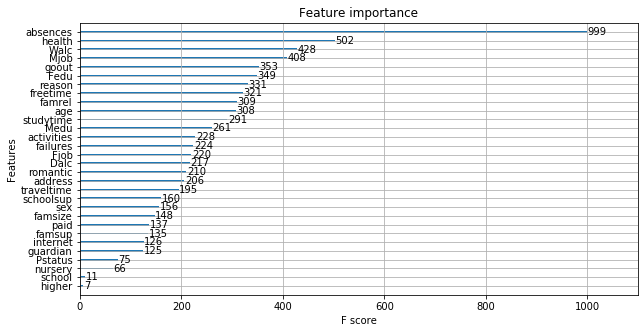

In [14]:
plot_importance(xgb)
plt.rcParams['figure.figsize']=(10,5)
plt.show()

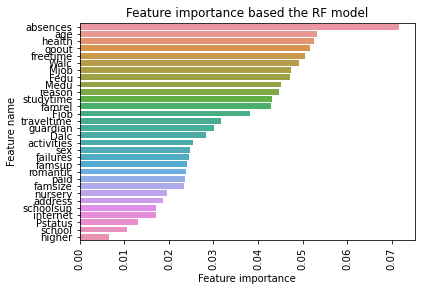

In [25]:
data = pd.read_csv('./student-mat.csv', sep=';')
cats = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
oe = OrdinalEncoder()
for c in cats:
    oe.fit(data[c].values.reshape(-1,1))
    data[c] = np.asarray(oe.transform(data[c].values.reshape(-1,1)),dtype=int)
#     np.asarray(data['gender'],dtype=int)
columns = cats[:-3]
data = data.values
data = shuffle(data)
rfc = RandomForestRegressor(random_state=0)
rfc.fit(data[:,:-3], data[:,-3])
dn = {'features':columns, 'score':rfc.feature_importances_}
df = pd.DataFrame.from_dict(data=dn).sort_values(by='score', ascending=False)
plot = sns.barplot(x='score', y='features', data=df, orient='h')
plot.set(xlabel='Feature importance', ylabel='Feature name')#, title='Feature importance from the RF model'
plt.setp(plot.get_xticklabels(), rotation=90)
plt.show()

# G3

In [33]:
mlps = np.array([[0.99707747, 1.31492872, 1.3310762 , 0.97537595],
       [0.93502896, 1.29689347, 1.3046003 , 0.97704604],
       [0.95485038, 1.28560976, 1.31046623, 0.97703797],
       [0.94034702, 1.2736213 , 1.28610021, 0.97724552],
       [0.96615943, 1.30702804, 1.33997015, 0.97617997],
       [0.96569512, 1.29726068, 1.32180246, 0.97579736],
       [0.97976258, 1.325866  , 1.34305269, 0.97577   ],
       [0.95960634, 1.30917472, 1.32214794, 0.97573037],
       [0.92982212, 1.23508301, 1.2644305 , 0.97823547],
       [0.9415223 , 1.27482387, 1.29217856, 0.97633897],
       [0.93567455, 1.28946312, 1.30107934, 0.97756025],
       [0.96598199, 1.27493508, 1.30514424, 0.97666665],
       [0.88798188, 1.18631768, 1.20867578, 0.97921325],
       [0.90814501, 1.22905587, 1.25149543, 0.97888207],
       [0.98638282, 1.34210171, 1.36297801, 0.9735624 ],
       [1.00897531, 1.36883935, 1.38434709, 0.97363725],
       [0.98151891, 1.33985636, 1.35524264, 0.97561961],
       [0.95196074, 1.25862543, 1.29708844, 0.97685877],
       [0.95878995, 1.273069  , 1.29050283, 0.97757565],
       [0.96386208, 1.31350073, 1.31887679, 0.97508607]])

svms = np.array([[0.8932838 , 1.27079095, 1.28971443, 0.97565111],
       [0.91148137, 1.28662554, 1.30031499, 0.9750223 ],
       [0.8967628 , 1.27786539, 1.29388203, 0.97692523],
       [0.89040328, 1.25956973, 1.28356535, 0.97747763],
       [0.89933336, 1.29258466, 1.30602664, 0.97654371],
       [0.91055869, 1.30605109, 1.32162947, 0.9761087 ],
       [0.93764133, 1.3336113 , 1.35929934, 0.97472409],
       [0.893899  , 1.25961702, 1.2774205 , 0.97710392],
       [0.90805782, 1.27723484, 1.29859192, 0.97677108],
       [0.91129126, 1.30387882, 1.31576077, 0.97637332],
       [0.89528293, 1.27445455, 1.29200274, 0.97682375],
       [0.88676384, 1.28746333, 1.30116405, 0.97665439],
       [0.89808326, 1.28622966, 1.30840744, 0.97603295],
       [0.90924043, 1.29105027, 1.30509336, 0.9765201 ],
       [0.89649755, 1.27437832, 1.29532457, 0.97607311],
       [0.91256574, 1.28875558, 1.30395414, 0.97669202],
       [0.90786688, 1.28754766, 1.32060657, 0.97653152],
       [0.88469328, 1.28532297, 1.29841089, 0.97674196],
       [0.90295189, 1.27246839, 1.30299762, 0.97566768],
       [0.91041802, 1.28464901, 1.31088785, 0.97585267]])

rfs = np.array([[0.83182526, 1.17491066, 1.19858552, 0.97986069],
       [0.86696493, 1.2534895 , 1.26491363, 0.97706539],
       [0.82883769, 1.20799127, 1.21503875, 0.9802264 ],
       [0.83762423, 1.19865612, 1.21653926, 0.97722119],
       [0.86456563, 1.269182  , 1.28639964, 0.97691218],
       [0.82684362, 1.1885683 , 1.21371958, 0.98052524],
       [0.83560321, 1.20988218, 1.21831218, 0.97920589],
       [0.82671726, 1.18288242, 1.19478292, 0.98052546],
       [0.85229704, 1.2217621 , 1.24297084, 0.97757993],
       [0.82360879, 1.19568807, 1.20614521, 0.97950026],
       [0.82096009, 1.18470958, 1.19902447, 0.97937062],
       [0.80775379, 1.15693568, 1.16726662, 0.98049027],
       [0.81794669, 1.17344164, 1.19037024, 0.98111051],
       [0.83498829, 1.20898235, 1.21658791, 0.97968481],
       [0.83941927, 1.21351044, 1.23888844, 0.97839646],
       [0.84237126, 1.2451738 , 1.26830969, 0.97778294],
       [0.83813452, 1.19318569, 1.21224339, 0.97895083],
       [0.83162158, 1.19710489, 1.22124338, 0.97835255],
       [0.83772285, 1.20025027, 1.23459619, 0.97894894],
       [0.86679102, 1.24610159, 1.26203321, 0.97810494]])

xgbs = np.array([[0.92795691, 1.23889667, 1.2574355 , 0.97785882],
       [0.91638959, 1.23299719, 1.26171332, 0.9784592 ],
       [0.92805038, 1.2477133 , 1.27447071, 0.97658365],
       [0.93886096, 1.24622559, 1.2566723 , 0.97862948],
       [0.95760238, 1.29674898, 1.31458134, 0.97594582],
       [0.96038143, 1.2563894 , 1.30732303, 0.97729808],
       [0.92684386, 1.2123639 , 1.23256474, 0.97730367],
       [0.94036525, 1.2931004 , 1.30451438, 0.97695481],
       [0.93372669, 1.22279925, 1.25881165, 0.97893012],
       [0.91691568, 1.23254747, 1.24322835, 0.97870797],
       [0.96502768, 1.26505243, 1.28314411, 0.97720041],
       [0.93081892, 1.26396517, 1.27070183, 0.97744049],
       [0.96754481, 1.31233312, 1.32323167, 0.97515812],
       [0.93442075, 1.25039556, 1.27177046, 0.97751692],
       [0.95678017, 1.27472028, 1.30346924, 0.97662728],
       [0.92976144, 1.27463683, 1.28987815, 0.97593047],
       [0.90504757, 1.23498078, 1.24655244, 0.97850547],
       [0.93178861, 1.25236822, 1.27269851, 0.97787922],
       [0.95779867, 1.29450559, 1.31129395, 0.97571259],
       [0.94974686, 1.28298252, 1.3064063 , 0.97636065]])

cats = np.array([[0.88232921, 1.17886056, 1.20231141, 0.97866678],
       [0.86349573, 1.17230465, 1.18457479, 0.98030227],
       [0.82671952, 1.11648112, 1.13500957, 0.98250472],
       [0.86166996, 1.16578668, 1.18036433, 0.98105838],
       [0.87545491, 1.18492741, 1.2024072 , 0.97899608],
       [0.87560527, 1.17570192, 1.19801584, 0.9807398 ],
       [0.85532336, 1.1740176 , 1.19213239, 0.9803785 ],
       [0.86984443, 1.18825488, 1.20233356, 0.98026954],
       [0.87327882, 1.18564364, 1.20598428, 0.97997223],
       [0.86661112, 1.16963886, 1.18490626, 0.97968924],
       [0.87273434, 1.16233448, 1.19948979, 0.97997501],
       [0.88087351, 1.18533624, 1.20033266, 0.97969718],
       [0.86189539, 1.15337374, 1.15913539, 0.98012481],
       [0.88733698, 1.21343437, 1.2364563 , 0.97874567],
       [0.89258936, 1.22199761, 1.23948202, 0.97946807],
       [0.87636858, 1.18572894, 1.19332075, 0.97963293],
       [0.89251619, 1.21829931, 1.2350811 , 0.97909123],
       [0.87159746, 1.19522023, 1.2052915 , 0.98080423],
       [0.90152874, 1.21524989, 1.24460457, 0.97950173],
       [0.85685102, 1.17673389, 1.18606465, 0.98036391]])

ccats = np.array([[0.76583467, 1.0167665 , 1.0272876 , 0.9843365 ],
       [0.78846116, 1.0964347 , 1.11075517, 0.98092457],
       [0.79100385, 1.074442  , 1.0927553 , 0.98237886],
       [0.80396211, 1.09707779, 1.12300741, 0.98071509],
       [0.78298712, 1.09345374, 1.1084239 , 0.98159457],
       [0.83757921, 1.1461678 , 1.16487428, 0.97926284],
       [0.83159386, 1.14653874, 1.15958265, 0.97982015],
       [0.80999489, 1.13694504, 1.14391828, 0.98061702],
       [0.81764764, 1.08755432, 1.11858763, 0.98215942],
       [0.81678722, 1.13484222, 1.1493447 , 0.98055932],
       [0.78545411, 1.06324887, 1.0707945 , 0.98272356],
       [0.80697275, 1.10240973, 1.1138489 , 0.98104996],
       [0.79917897, 1.09221661, 1.10232145, 0.98073661],
       [0.81706184, 1.09604417, 1.10954777, 0.98154917],
       [0.77138164, 1.02815531, 1.04847745, 0.98372102],
       [0.78665409, 1.08941695, 1.09774015, 0.98236917],
       [0.82258893, 1.12409884, 1.14366262, 0.98018298],
       [0.81048442, 1.0951784 , 1.11759401, 0.98205836],
       [0.80395234, 1.08264912, 1.09812756, 0.98200607],
       [0.80181067, 1.07640763, 1.09735256, 0.98138069]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


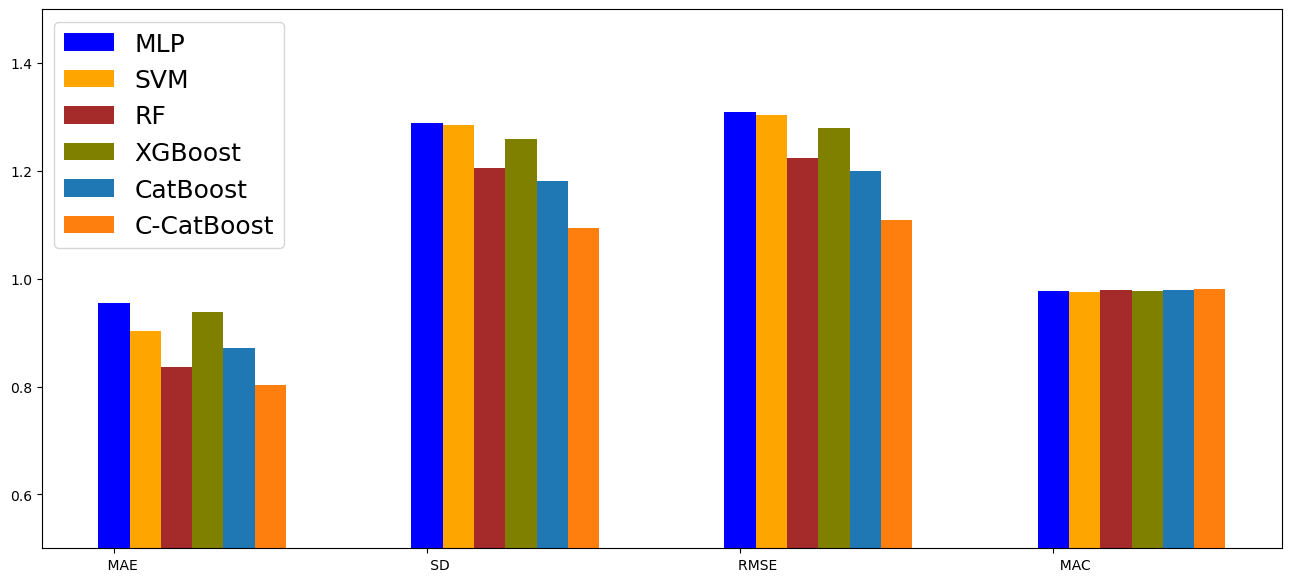

In [7]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


mlp = np.mean(mlps, axis=0)
svm = np.mean(svms, axis=0)
rf = np.mean(rfs, axis=0)
xgb = np.mean(xgbs, axis=0)
cat = np.mean(cats, axis=0)
ccat = np.mean(ccats, axis=0)
names = ['    MAE', '      SD','        RMSE','          MAC']

figure(num=None, figsize=(16, 7))
y_pos=np.arange(len(names))
plt.bar(y_pos + 0, mlp,width=0.1, color = 'blue' , label='MLP')
plt.bar(y_pos + 0.1, svm,width=0.1, color = 'orange' , label='SVM')
plt.bar(y_pos + 0.2, rf,width=0.1, color = 'brown' , label='RF')
plt.bar(y_pos + 0.3, xgb,width=0.1, color = 'olive' , label='XGBoost')
plt.bar(y_pos + 0.4, cat,width=0.1, label='CatBoost')
plt.bar(y_pos + 0.5, ccat,width=0.1, label='C-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 18}
plt.rcParams.update({'font.size': 18})
plt.rc('font', **font)
plt.ylim(0.5, 1.5)
plt.xticks(y_pos, names)
plt.legend(('MLP', 'SVM','RF','XGBoost','CatBoost','C-CatBoost'),loc='upper left')
plt.savefig('mathG3C.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

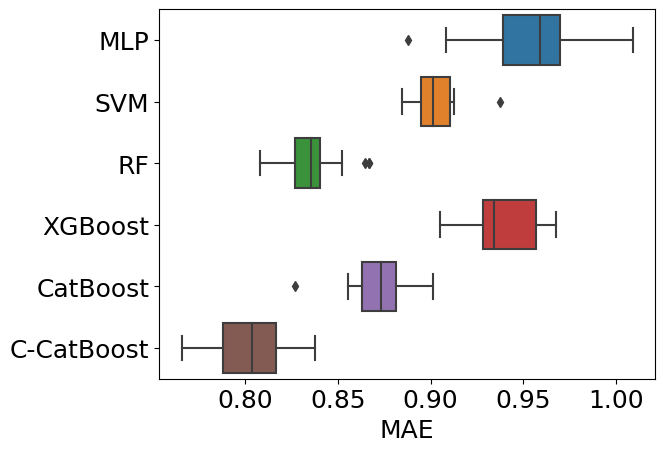

In [10]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 0
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="MAE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('mathMAEG3.eps', format='eps',bbox_inches  ='tight')

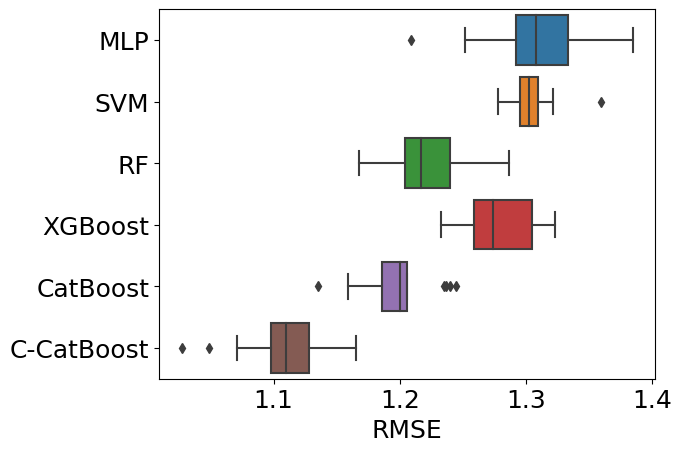

In [11]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 2
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="RMSE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('mathRMSEG3.eps', format='eps',bbox_inches  ='tight')

In [34]:
# for i in range(4):
#     print(ranksums(mlp[:,i], svm[:,i]).pvalue)
# i=0
for i in range(4):
    print(ranksums(ccats[:,i], mlps[:,i]).pvalue)
    print(ranksums(ccats[:,i], svms[:,i]).pvalue)
    print(ranksums(ccats[:,i], rfs[:,i]).pvalue)
    print(ranksums(ccats[:,i], xgbs[:,i]).pvalue)
    print(ranksums(ccats[:,i], cats[:,i]).pvalue)
    print()


6.301848221392269e-08
6.301848221392269e-08
2.517398557413545e-06
6.301848221392269e-08
8.512328416895721e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
1.329245985375027e-07

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
1.7827968013624886e-07

6.301848221392269e-08
6.301848221392269e-08
2.517398557413545e-06
6.301848221392269e-08
0.00021067282571316564



# G2

In [31]:
mlps = np.array([[1.28729527, 1.66761169, 1.69465306, 0.96081566],
       [1.33716969, 1.68245326, 1.71322325, 0.95762573],
       [1.3426386 , 1.72244095, 1.75009748, 0.95852648],
       [1.32302518, 1.69476533, 1.72371515, 0.9596608 ],
       [1.36895669, 1.75858129, 1.80824048, 0.95659332],
       [1.32542641, 1.67143663, 1.69326491, 0.9605398 ],
       [1.33209954, 1.7217121 , 1.74758853, 0.95869911],
       [1.33013777, 1.73027269, 1.74503442, 0.95828112],
       [1.35258567, 1.71329656, 1.74406753, 0.95805875],
       [1.3231658 , 1.71294448, 1.74200112, 0.95780735],
       [1.32573471, 1.68198113, 1.71361254, 0.95941005],
       [1.31728488, 1.66813446, 1.70573975, 0.95791277],
       [1.3203635 , 1.69760935, 1.724421  , 0.95894337],
       [1.34738581, 1.71103934, 1.75234674, 0.95801649],
       [1.34489217, 1.71034725, 1.75195853, 0.95892036],
       [1.32375054, 1.67383614, 1.70405118, 0.95981407],
       [1.3720863 , 1.75507075, 1.77918908, 0.95643323],
       [1.33432566, 1.72166452, 1.73468203, 0.9590855 ],
       [1.3351295 , 1.70062557, 1.71496482, 0.95900653],
       [1.29139775, 1.65237683, 1.67218914, 0.96004447]])
svms = np.array([[1.18502796, 1.58793702, 1.60844628, 0.96410172],
       [1.23392424, 1.63778581, 1.6497165 , 0.96106619],
       [1.196841  , 1.58558036, 1.60286973, 0.96324208],
       [1.20152872, 1.56825912, 1.59334753, 0.962564  ],
       [1.19661022, 1.5721169 , 1.60902873, 0.96457885],
       [1.19266638, 1.59178557, 1.61003892, 0.96461254],
       [1.20544697, 1.59924118, 1.62070187, 0.96259873],
       [1.20325374, 1.59967749, 1.62210732, 0.96242066],
       [1.19618686, 1.55481806, 1.57492428, 0.96401364],
       [1.19660292, 1.5860296 , 1.62588983, 0.96367382],
       [1.20590763, 1.58738877, 1.62069444, 0.96251804],
       [1.17483772, 1.51619662, 1.54787293, 0.96757361],
       [1.21952067, 1.6226717 , 1.63495761, 0.96212081],
       [1.21774501, 1.58706969, 1.62505098, 0.9624592 ],
       [1.20654578, 1.61307153, 1.63562423, 0.96357338],
       [1.20817652, 1.61084832, 1.62007132, 0.96247123],
       [1.22753259, 1.63262583, 1.64845259, 0.96145237],
       [1.19044872, 1.6072785 , 1.61604074, 0.96347676],
       [1.20277743, 1.59819646, 1.62262842, 0.96248051],
       [1.21577758, 1.62071191, 1.63304613, 0.96236569]])
rfs = np.array([[1.23983014, 1.65171374, 1.66165189, 0.96039617],
       [1.23164538, 1.63326173, 1.66721369, 0.96210537],
       [1.23563243, 1.60017322, 1.63714875, 0.96314253],
       [1.21732776, 1.59933827, 1.61690179, 0.96422114],
       [1.24287391, 1.65056626, 1.6667916 , 0.96101327],
       [1.23025497, 1.5943242 , 1.61467641, 0.96320008],
       [1.22160967, 1.6045603 , 1.61693999, 0.96243252],
       [1.23924577, 1.6078224 , 1.6693553 , 0.96135911],
       [1.23747536, 1.65606896, 1.68011052, 0.96120993],
       [1.24416831, 1.64243143, 1.66248122, 0.96116786],
       [1.24931415, 1.60402483, 1.65412551, 0.9622815 ],
       [1.26752487, 1.63985272, 1.69000557, 0.95990265],
       [1.22754613, 1.63089598, 1.64773177, 0.96083431],
       [1.21245866, 1.6115381 , 1.62259193, 0.96273456],
       [1.22969615, 1.62058623, 1.65215813, 0.96202497],
       [1.25188206, 1.64943473, 1.66856875, 0.95980162],
       [1.25736947, 1.66498066, 1.70026931, 0.95992367],
       [1.23968584, 1.63322817, 1.67101613, 0.95845763],
       [1.21473643, 1.63017023, 1.64437635, 0.96197033],
       [1.21414459, 1.60742108, 1.61980392, 0.96101336]])
xgbs = np.array([[1.34931764, 1.77277287, 1.79786535, 0.95490253],
       [1.37722344, 1.81057021, 1.8222248 , 0.95273239],
       [1.39260287, 1.79399435, 1.83128899, 0.95320098],
       [1.33800109, 1.74520165, 1.78893266, 0.95602685],
       [1.3866781 , 1.79553982, 1.8211394 , 0.95404688],
       [1.35100711, 1.77990774, 1.8122711 , 0.95453129],
       [1.40572684, 1.82100447, 1.85615379, 0.95343453],
       [1.34941383, 1.78761486, 1.80959959, 0.95485504],
       [1.37867043, 1.80482709, 1.81936563, 0.95408213],
       [1.3570786 , 1.81215023, 1.83231386, 0.95411331],
       [1.3854553 , 1.77103267, 1.79281817, 0.95296433],
       [1.35719442, 1.81978984, 1.82996291, 0.95353377],
       [1.36789156, 1.8287413 , 1.85235132, 0.9498208 ],
       [1.38260581, 1.87203745, 1.88007252, 0.95029788],
       [1.38744537, 1.78892849, 1.81771179, 0.95374494],
       [1.34829096, 1.77611894, 1.79531303, 0.95332419],
       [1.36983652, 1.77235722, 1.80978555, 0.95550963],
       [1.35369839, 1.73936843, 1.75974776, 0.95616939],
       [1.44497722, 1.85305821, 1.89165411, 0.95173216],
       [1.36206117, 1.80131143, 1.8277543 , 0.9535383 ]])
cats = np.array([[1.25964623, 1.67137939, 1.70960562, 0.95936836],
       [1.21393181, 1.61826479, 1.65280139, 0.96087946],
       [1.27681211, 1.69463904, 1.72044744, 0.95903507],
       [1.29147511, 1.72487873, 1.74886893, 0.95805864],
       [1.2368958 , 1.6467865 , 1.67321071, 0.96149297],
       [1.24202327, 1.63986714, 1.67546813, 0.95978338],
       [1.25284546, 1.63964166, 1.65545017, 0.96165391],
       [1.22812154, 1.63899932, 1.65962357, 0.96103997],
       [1.28448051, 1.67099475, 1.69323099, 0.95830937],
       [1.24609454, 1.64116427, 1.6618853 , 0.96106381],
       [1.23026386, 1.64525618, 1.66685068, 0.96207791],
       [1.24012347, 1.62656463, 1.66307773, 0.96123394],
       [1.24745484, 1.67209457, 1.7000539 , 0.95957022],
       [1.25159878, 1.66248102, 1.68105957, 0.96067364],
       [1.27088361, 1.68888295, 1.70028691, 0.95909973],
       [1.26976109, 1.67194836, 1.69239575, 0.95880266],
       [1.27320873, 1.67746894, 1.68977278, 0.95916573],
       [1.23197484, 1.63224286, 1.64264493, 0.96225742],
       [1.21268698, 1.60861116, 1.62182341, 0.96269091],
       [1.24466714, 1.65398101, 1.6806738 , 0.96026578]])

ccats = np.array([[1.14316844, 1.50934309, 1.52098062, 0.96506902],
       [1.21492558, 1.58362163, 1.61098353, 0.96370884],
       [1.17947296, 1.56121066, 1.57881267, 0.96405243],
       [1.18420039, 1.57510557, 1.58360154, 0.9625179 ],
       [1.17560248, 1.50740245, 1.54003221, 0.96679937],
       [1.20877525, 1.59939575, 1.62100766, 0.95994035],
       [1.18898266, 1.57697916, 1.59927949, 0.96348854],
       [1.18781601, 1.52846376, 1.56493964, 0.96455108],
       [1.14010043, 1.48043577, 1.50440366, 0.96784243],
       [1.18460148, 1.54461045, 1.55866095, 0.96319566],
       [1.2153428 , 1.58439965, 1.59929024, 0.96187757],
       [1.19010949, 1.565709  , 1.57733772, 0.96467307],
       [1.19717832, 1.5900257 , 1.60115569, 0.96124053],
       [1.23875155, 1.63148638, 1.66456831, 0.95967526],
       [1.2322132 , 1.60487113, 1.62572634, 0.96139619],
       [1.16629454, 1.51973099, 1.54932216, 0.96438554],
       [1.18738126, 1.58880856, 1.59566127, 0.96209489],
       [1.18254368, 1.54111858, 1.5584862 , 0.96391432],
       [1.19380816, 1.52694131, 1.55539559, 0.96550012],
       [1.18690646, 1.56570148, 1.60072312, 0.96336087]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


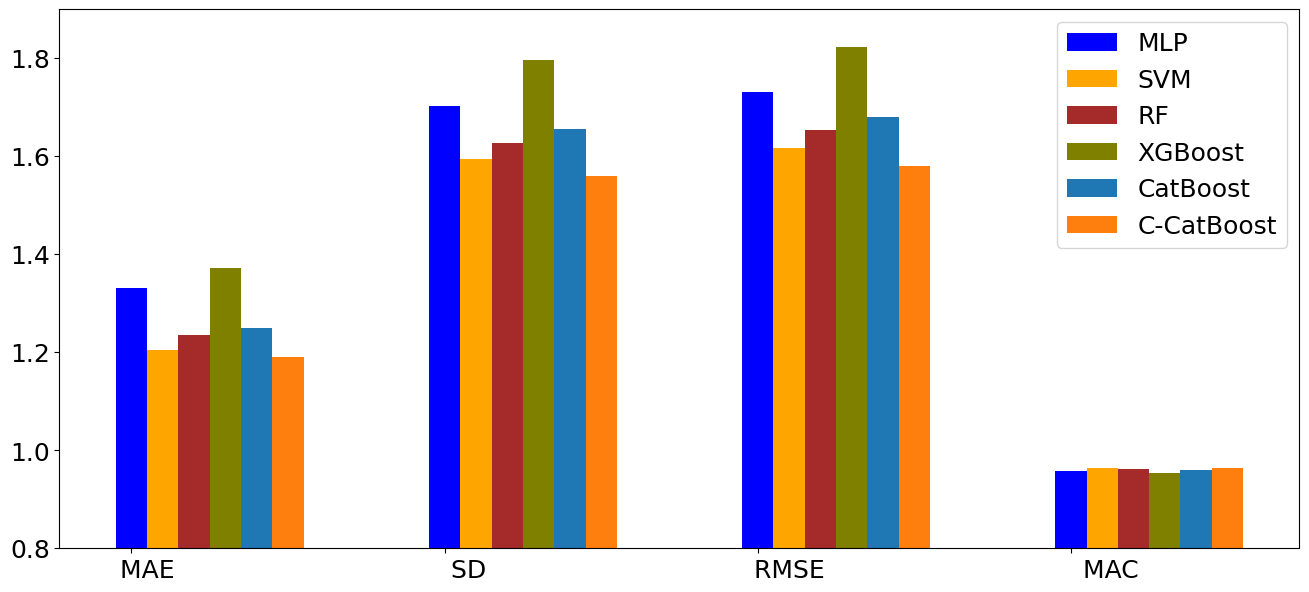

In [28]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


mlp = np.mean(mlps, axis=0)
svm = np.mean(svms, axis=0)
rf = np.mean(rfs, axis=0)
xgb = np.mean(xgbs, axis=0)
cat = np.mean(cats, axis=0)
ccat = np.mean(ccats, axis=0)
names = ['    MAE', '      SD','        RMSE','          MAC']

figure(num=None, figsize=(16, 7))
y_pos=np.arange(len(names))
plt.bar(y_pos + 0, mlp,width=0.1, color = 'blue' , label='MLP')
plt.bar(y_pos + 0.1, svm,width=0.1, color = 'orange' , label='SVM')
plt.bar(y_pos + 0.2, rf,width=0.1, color = 'brown' , label='RF')
plt.bar(y_pos + 0.3, xgb,width=0.1, color = 'olive' , label='XGBoost')
plt.bar(y_pos + 0.4, cat,width=0.1, label='CatBoost')
plt.bar(y_pos + 0.5, ccat,width=0.1, label='C-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 18}
plt.rcParams.update({'font.size': 18})
plt.rc('font', **font)
plt.ylim(0.8, 1.9)
plt.xticks(y_pos, names)
plt.legend(('MLP', 'SVM','RF','XGBoost','CatBoost','C-CatBoost'),loc='upper right')
plt.savefig('mathG2C.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

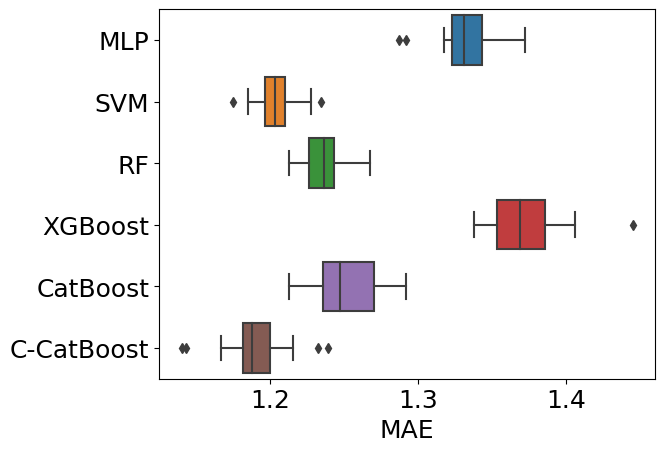

In [14]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 0
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="MAE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('mathMAEG2.eps', format='eps',bbox_inches  ='tight')

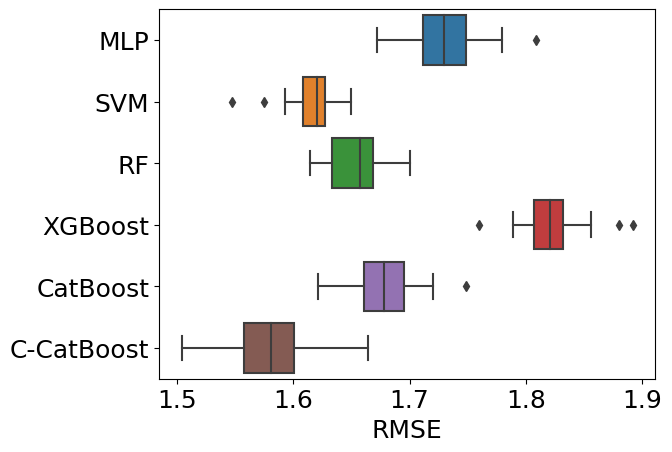

In [15]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 2
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="RMSE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('mathRMSEG2.eps', format='eps',bbox_inches  ='tight')

In [32]:
# for i in range(4):
#     print(ranksums(mlp[:,i], svm[:,i]).pvalue)
# i=0
for i in range(4):
    print(ranksums(ccats[:,i], mlps[:,i]).pvalue)
    print(ranksums(ccats[:,i], svms[:,i]).pvalue)
    print(ranksums(ccats[:,i], rfs[:,i]).pvalue)
    print(ranksums(ccats[:,i], xgbs[:,i]).pvalue)
    print(ranksums(ccats[:,i], cats[:,i]).pvalue)
    print()


6.301848221392269e-08
0.01606401314826911
2.517398557413545e-06
6.301848221392269e-08
5.607514411947966e-07

6.301848221392269e-08
0.0024486973708739636
8.517683792974374e-07
6.301848221392269e-08
9.882703709104184e-08

6.301848221392269e-08
0.000966466416708517
1.2856080534514384e-06
6.301848221392269e-08
2.062471174491123e-07

1.7827968013624886e-07
0.4818673682837039
0.0012865616350960295
6.301848221392269e-08
1.3302784217079512e-05



# G1

In [29]:
mlps = np.array([[2.59468243, 3.12403587, 3.17850379, 0.8626449 ],
       [2.57994285, 3.12586418, 3.16534398, 0.86401999],
       [2.60050645, 3.14987665, 3.1810394 , 0.86267754],
       [2.56664119, 3.09594197, 3.16697893, 0.86576168],
       [2.60316827, 3.13977569, 3.17817444, 0.86441766],
       [2.55568111, 3.09485388, 3.1524746 , 0.86926826],
       [2.58841808, 3.15320407, 3.18942858, 0.8649676 ],
       [2.52748142, 3.09304241, 3.15822446, 0.86781746],
       [2.60290621, 3.177441  , 3.20666579, 0.86241657],
       [2.52780339, 3.13477355, 3.14694223, 0.86502781],
       [2.55615058, 3.20854855, 3.22658693, 0.8603178 ],
       [2.48039727, 3.06580402, 3.09060958, 0.87110098],
       [2.58625829, 3.1561901 , 3.18731324, 0.86380467],
       [2.60170745, 3.16184535, 3.26496408, 0.8611375 ],
       [2.5141229 , 3.05630507, 3.17892704, 0.87170088],
       [2.60364519, 3.11652572, 3.16987342, 0.86591777],
       [2.56701679, 3.15019246, 3.16460693, 0.86344402],
       [2.63451159, 3.23617649, 3.2619455 , 0.85888528],
       [2.62256425, 3.16489171, 3.22265351, 0.86277299],
       [2.59010244, 3.18028113, 3.22413952, 0.86129723]])

svms = np.array([[2.521741  , 3.03372632, 3.07532001, 0.87124644],
       [2.52451066, 3.07614085, 3.10254508, 0.87000204],
       [2.56200322, 3.06794295, 3.10988758, 0.871761  ],
       [2.51548618, 2.98539051, 3.07664353, 0.87430623],
       [2.55152262, 3.07244156, 3.12315302, 0.87036003],
       [2.53394669, 3.029243  , 3.07450977, 0.87274655],
       [2.54947616, 3.01632691, 3.10070613, 0.87565558],
       [2.5517838 , 3.04281036, 3.10781853, 0.8720367 ],
       [2.54377959, 3.0221353 , 3.07551878, 0.8738822 ],
       [2.51776724, 3.04549856, 3.08606062, 0.87240303],
       [2.5232236 , 3.01029795, 3.06235537, 0.87422741],
       [2.55215787, 3.05175735, 3.09654996, 0.8724554 ],
       [2.53138705, 3.07135469, 3.09784259, 0.87133893],
       [2.51444029, 3.05362504, 3.07927001, 0.8713479 ],
       [2.51970771, 3.01915576, 3.07479156, 0.87331124],
       [2.56880238, 3.04184879, 3.12298484, 0.8717347 ],
       [2.52519773, 3.06552421, 3.10429156, 0.87152972],
       [2.51307577, 3.02606917, 3.06621916, 0.87439756],
       [2.50614998, 3.04397682, 3.07745107, 0.87192986],
       [2.54212548, 3.04610812, 3.10597646, 0.8710574 ]])

rfs = np.array([[2.51019141, 2.98229978, 3.02378991, 0.87780918],
       [2.47711141, 2.93156639, 2.98138173, 0.88125092],
       [2.47091217, 2.94688651, 2.98905978, 0.88045895],
       [2.45884325, 2.91985384, 2.96657872, 0.8826239 ],
       [2.49400524, 2.9681212 , 3.0074232 , 0.87703937],
       [2.43979387, 2.90354208, 2.9421548 , 0.88555991],
       [2.48771526, 2.93957307, 3.00754481, 0.87974387],
       [2.48849494, 2.96477531, 2.99323353, 0.87915219],
       [2.46754839, 2.93772146, 2.97628516, 0.88228739],
       [2.47139008, 2.95318531, 2.98143141, 0.87923551],
       [2.46347135, 2.94657523, 2.97285028, 0.88051014],
       [2.46669589, 2.93457217, 2.98146205, 0.88266861],
       [2.50302132, 2.92449119, 3.00504002, 0.88153145],
       [2.50291048, 2.94535333, 3.02520561, 0.88045735],
       [2.47555999, 2.95215556, 2.97791894, 0.8810218 ],
       [2.47663674, 2.94985154, 2.98033226, 0.88024772],
       [2.48986395, 2.9473827 , 3.00018431, 0.87863272],
       [2.51001634, 2.9828323 , 3.00909753, 0.87893606],
       [2.47360924, 2.90898331, 2.97774778, 0.8831099 ],
       [2.47694497, 2.92429624, 2.97157874, 0.88328841]])

xgbs = np.array([[2.60575523, 3.12268965, 3.19168116, 0.8662134 ],
       [2.58985802, 3.11727713, 3.17452467, 0.8657586 ],
       [2.49339203, 3.03777081, 3.09646769, 0.8716595 ],
       [2.62192655, 3.19668959, 3.22500672, 0.86028641],
       [2.65247012, 3.2029907 , 3.27748615, 0.85994153],
       [2.54015171, 3.14218837, 3.17239575, 0.86457707],
       [2.53098312, 3.08031477, 3.09708831, 0.86967046],
       [2.64356589, 3.21540345, 3.25097989, 0.85641564],
       [2.65112369, 3.15603713, 3.20666709, 0.86161642],
       [2.71877644, 3.30962413, 3.3352083 , 0.84887177],
       [2.70330941, 3.21896042, 3.27602779, 0.85941011],
       [2.59488415, 3.11604698, 3.17696485, 0.86612801],
       [2.65735838, 3.19612232, 3.2455235 , 0.85961406],
       [2.55923402, 3.08913753, 3.15880726, 0.86845841],
       [2.69473884, 3.2800463 , 3.30183399, 0.85353347],
       [2.7125788 , 3.25278262, 3.31147566, 0.85683032],
       [2.65209269, 3.22213001, 3.24415189, 0.85766808],
       [2.59713166, 3.17934935, 3.20931824, 0.86162025],
       [2.64399265, 3.22118438, 3.26053558, 0.85841394],
       [2.68734659, 3.24250291, 3.27108074, 0.85621765]])

cats = np.array([[2.45628369, 2.98420018, 3.03216785, 0.87797769],
       [2.5860907 , 3.11620579, 3.16770999, 0.86734304],
       [2.58459279, 3.09163751, 3.12900469, 0.86815959],
       [2.50057522, 2.96742405, 3.07291515, 0.87641039],
       [2.4931209 , 2.97692019, 3.06314623, 0.87645728],
       [2.48232405, 3.00633535, 3.05956996, 0.8747511 ],
       [2.44670257, 3.01487231, 3.02902174, 0.8747701 ],
       [2.48216276, 2.99976513, 3.06226551, 0.87516607],
       [2.50184142, 3.03027314, 3.07936254, 0.87319281],
       [2.51854758, 3.03642346, 3.08515829, 0.87334465],
       [2.47043761, 2.99024949, 3.03367215, 0.87715899],
       [2.58026861, 3.08255357, 3.12694312, 0.87132561],
       [2.55013304, 3.0990341 , 3.13034032, 0.86732771],
       [2.5093276 , 3.0586678 , 3.07768007, 0.87221222],
       [2.46379334, 3.0071175 , 3.05559371, 0.87583834],
       [2.49278886, 2.99837155, 3.0347872 , 0.87621839],
       [2.48681587, 3.00332385, 3.03193313, 0.87567947],
       [2.51826773, 3.01478204, 3.07190637, 0.87476644],
       [2.45347213, 2.94567188, 2.98880085, 0.88088163],
       [2.47963278, 2.96419684, 3.0321054 , 0.88040992]])

ccats = np.array([[2.30492833, 2.8023857 , 2.82750521, 0.88228631],
       [2.26533559, 2.74744068, 2.79950482, 0.8863787 ],
       [2.30556786, 2.79266836, 2.82465759, 0.88275461],
       [2.28742801, 2.76259478, 2.82338387, 0.88281532],
       [2.2990975 , 2.78638552, 2.82091401, 0.88460092],
       [2.27916147, 2.75981181, 2.841232  , 0.88633295],
       [2.28317503, 2.78511243, 2.84650281, 0.88307449],
       [2.31728378, 2.81432683, 2.85830485, 0.88264455],
       [2.26540423, 2.7250951 , 2.78615613, 0.88559813],
       [2.35864057, 2.84003613, 2.86783036, 0.88188687],
       [2.2771454 , 2.81896677, 2.83396175, 0.88345187],
       [2.29166906, 2.77781389, 2.8218843 , 0.88397905],
       [2.27598703, 2.70920147, 2.77390244, 0.89139165],
       [2.33015989, 2.83169162, 2.87261252, 0.88126483],
       [2.3456147 , 2.82739018, 2.8995199 , 0.88040709],
       [2.334734  , 2.77575248, 2.85580698, 0.88366199],
       [2.28717415, 2.81413128, 2.85706672, 0.88474901],
       [2.26276745, 2.77438301, 2.80987729, 0.88756696],
       [2.25767356, 2.71401784, 2.78608944, 0.89134281],
       [2.40593359, 2.86237818, 2.90806551, 0.8797521 ]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


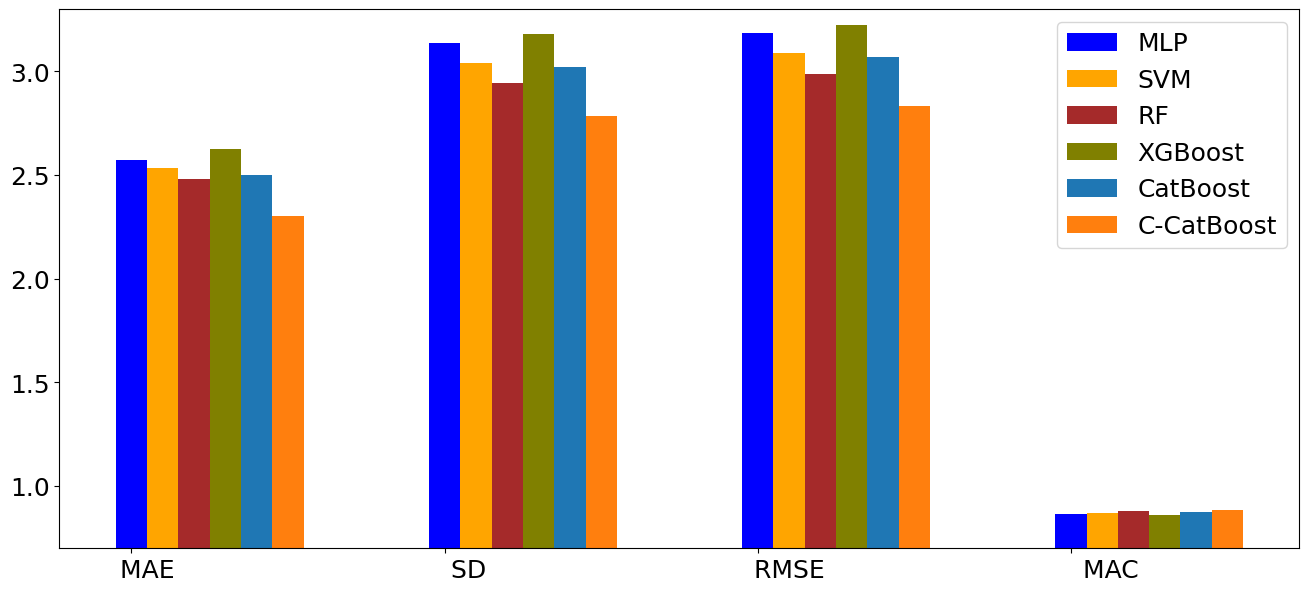

In [23]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt


mlp = np.mean(mlps, axis=0)
svm = np.mean(svms, axis=0)
rf = np.mean(rfs, axis=0)
xgb = np.mean(xgbs, axis=0)
cat = np.mean(cats, axis=0)
ccat = np.mean(ccats, axis=0)
names = ['    MAE', '      SD','        RMSE','          MAC']

figure(num=None, figsize=(16, 7))
y_pos=np.arange(len(names))
plt.bar(y_pos + 0, mlp,width=0.1, color = 'blue' , label='MLP')
plt.bar(y_pos + 0.1, svm,width=0.1, color = 'orange' , label='SVM')
plt.bar(y_pos + 0.2, rf,width=0.1, color = 'brown' , label='RF')
plt.bar(y_pos + 0.3, xgb,width=0.1, color = 'olive' , label='XGBoost')
plt.bar(y_pos + 0.4, cat,width=0.1, label='CatBoost')
plt.bar(y_pos + 0.5, ccat,width=0.1, label='C-CatBoost')

font = {
#     'family' : 'Times New Roman',
#         'weight' : 'bold',
        'size'   : 18}
plt.rcParams.update({'font.size': 18})
plt.rc('font', **font)
plt.ylim(0.7, 3.3)
plt.xticks(y_pos, names)
plt.legend(('MLP', 'SVM','RF','XGBoost','CatBoost','C-CatBoost'),loc='upper right')
plt.savefig('mathG1C.eps', format='eps',bbox_inches='tight')
# plt.title("Put a title here")
plt.show()

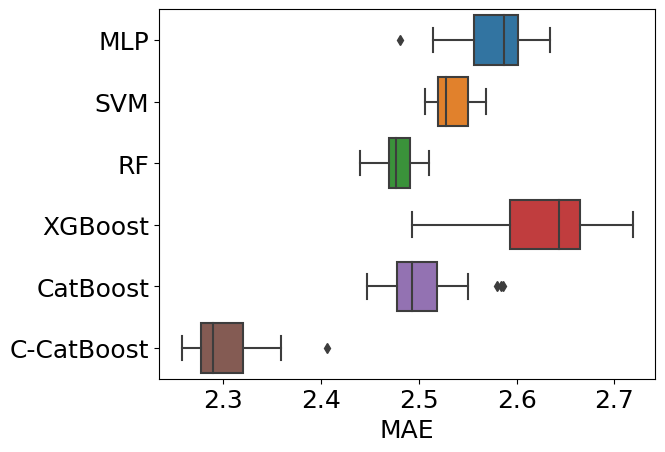

In [18]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 0
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="MAE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('mathMAEG1.eps', format='eps',bbox_inches  ='tight')

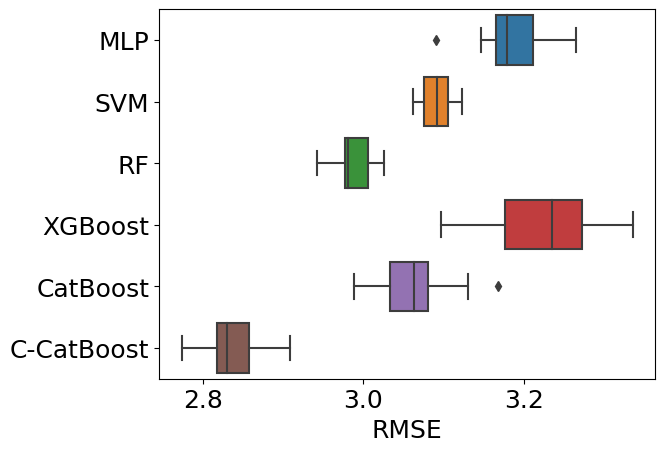

In [19]:
df = pd.DataFrame(columns=['MLP', 'SVM',"RF","XGBoost","CatBoost",'C-CatBoost'])
i = 2
df["MLP"] = mlps[:, i]
df["SVM"] = svms[:, i]
df["RF"] = rfs[:, i]
df["XGBoost"] = xgbs[:, i]
df["CatBoost"] = cats[:, i]
df["C-CatBoost"] = ccats[:, i]
ax = sns.boxplot(data=df,orient='h')#, x=x, y=y, hue=hue
# add_stat_annotation(ax, data=df,
#                     box_pairs=[("ANN", "FW-LS-SVM"), ("SVM", "FW-LS-SVM"),
#                                  ("LS-SVM", "FW-LS-SVM")
#                                 ],
#                     test='t-test_ind', text_format='full', loc='inside', verbose=2)
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax.set(xlabel="RMSE")

# plt.savefig('ensembleUCI.eps', format='eps')
plt.savefig('mathRMSEG1.eps', format='eps',bbox_inches  ='tight')

In [30]:
# for i in range(4):
#     print(ranksums(mlp[:,i], svm[:,i]).pvalue)
# i=0
for i in range(4):
    print(ranksums(ccats[:,i], mlps[:,i]).pvalue)
    print(ranksums(ccats[:,i], svms[:,i]).pvalue)
    print(ranksums(ccats[:,i], rfs[:,i]).pvalue)
    print(ranksums(ccats[:,i], xgbs[:,i]).pvalue)
    print(ranksums(ccats[:,i], cats[:,i]).pvalue)
    print()


6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08
6.301848221392269e-08

6.301848221392269e-08
6.301848221392269e-08
0.0001892785216405046
6.301848221392269e-08
1.1465546070186533e-07

